In [27]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

In [28]:
data_folder = '/kaggle/working/'
fmnist = datasets.FashionMNIST(data_folder, download = True, train = True)
X, y = fmnist.data, fmnist.targets

In [29]:
X_train.shape

torch.Size([48000, 28, 28])

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [31]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([ # cria uma pipeline sequencial de augmenters
    iaa.Affine(translate_px={'x': (-10, 10)}, mode='constant') # aplica uma transformação linear de translação no eixo x, preenchendo os pixels que "sobram" do lado oposto com um valor constante
])

In [32]:
# criação do construtor do dataset
class MyFMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch):
        ims, classes = list(zip(*batch)) # * separa as tuplas em batch
        if self.aug: # se tem um parâmetro de augmentation
            ims_np = np.array([tensor.numpy() for tensor in ims]) # converte as imagens de tensor pra array numpy
            ims = self.aug.augment_images(images=ims_np) # aplica a augmentation
        
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.0 # converte de volta pra tensor, adiciona a dimensão extra, aloca na gpu, normaliza e converte pra float
        classes = torch.tensor(classes).to(device) # garante que o conjunto de classes está em forma de tensor e aloca na gpu
        return ims, classes # retorna o batch com agumentation
        

In [33]:
from torch.optim import Adam
import torch.nn as nn

# criação da função que retorna a rede neural
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, 3), # in 1x28x28, out 64x26x26, because of N - K + 1
        nn.MaxPool2d(2), # in 64x26x26, out 64x13x13
        nn.ReLU(), 
        nn.Conv2d(64, 128, 3), # in 64x13x13, out 128x11x11
        nn.MaxPool2d(2), # in 128x11x11, out 128x5x5
        nn.ReLU(),
        nn.Flatten(), # in 128x5x5, out 3200
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = Adam(model.parameters(), lr = 0.001)
    return model, loss_fn, opt

In [34]:
# função de treino de batch
def train_batch(model, x, y, loss_fn, opt):
    model.train() # coloca o modelo em modo de treino
    predictions = model(x)
    batch_loss = loss_fn(predictions, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [35]:
# função que cria e retorna o dataloader de treino
def get_data():
    train_ds = MyFMNISTDataset(X_train, y_train, aug)
    train_dl = DataLoader(train_ds, batch_size=64, 
                         collate_fn = train_ds.collate_fn, shuffle=True)
    return train_dl

In [36]:
train_dl = get_data()
model, loss_fn, opt = get_model()

In [37]:
# loop de treino
for epoch in range(5):
    print(epoch)
    epoch_train_losses, epoch_train_accs = [], []
    for batch in iter(train_dl):
        x, y = batch
        batch_loss = train_batch(model, x, y, loss_fn, opt)

0
1
2
3
4


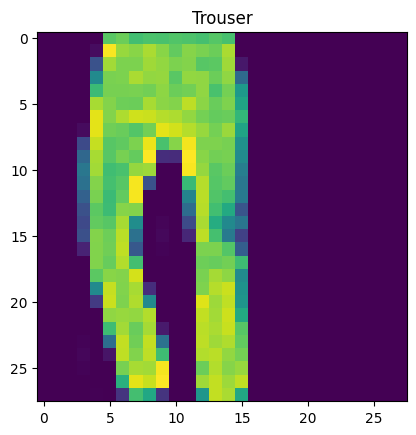

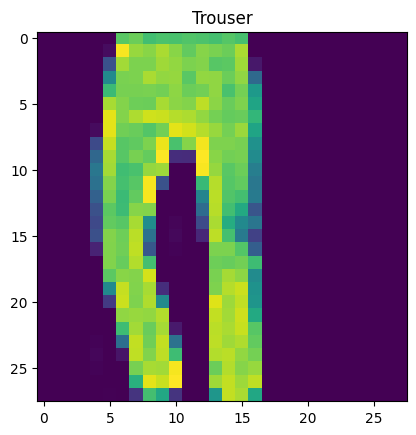

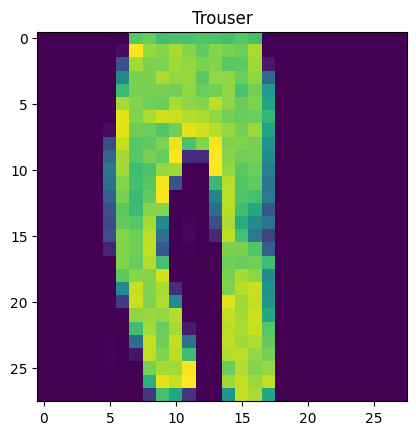

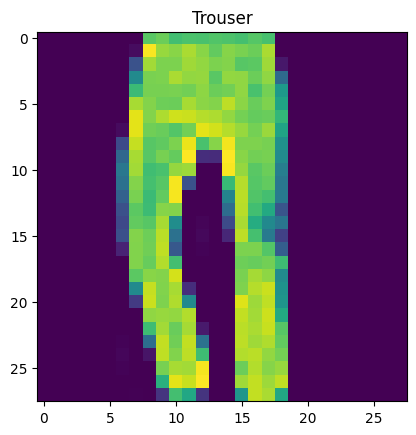

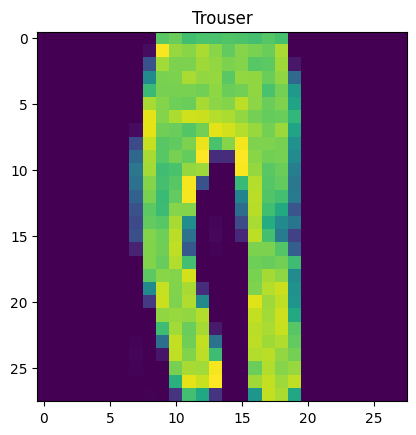

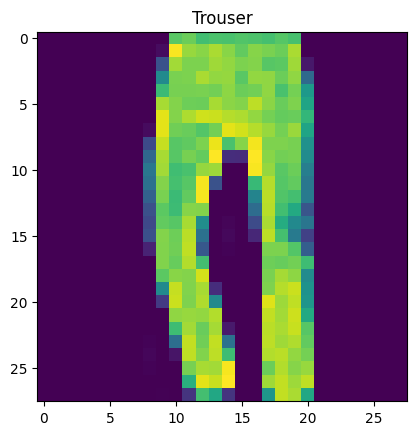

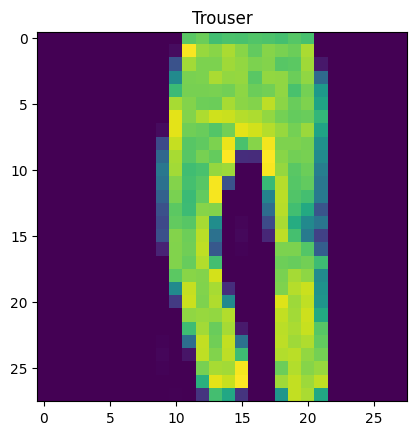

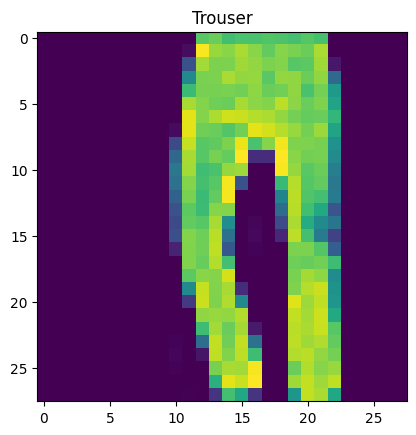

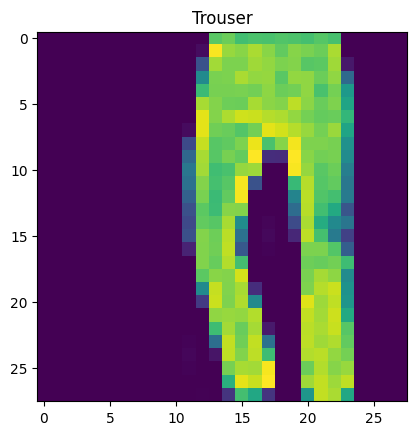

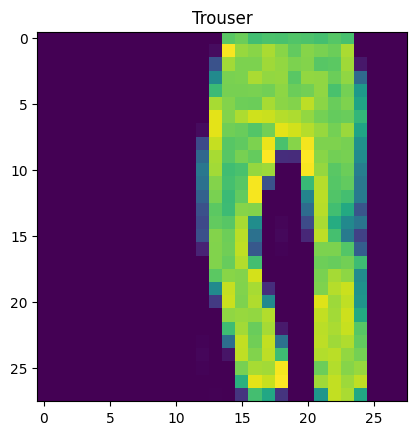

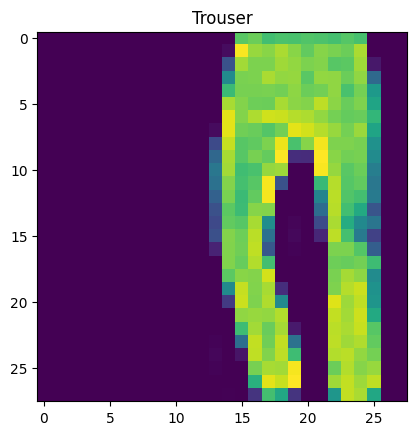

In [40]:
import matplotlib.pyplot as plt
preds = []
ix = 24300
for px in range(-5,6):
    img = X[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()